In [1]:
import pandas as pd
import numpy as np
import string
import scipy as sp
from math import ceil
import seaborn as sns
from glob import glob
from Bio import pairwise2, SeqIO, Seq
import ternary
from matplotlib_venn import venn2_unweighted, venn3, venn3_circles, venn3_unweighted
import gffpandas.gffpandas as gffpd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import copy
import pycircos
from Bio.SeqUtils import GC
import textwrap
import math
import matplotlib.gridspec as gridspec

sns.set_context(rc = {'legend.fontsize': 8, 'ytick.labelsize': 8, 'xtick.labelsize':8, 'axes.labelsize':8})
matplotlib.rcParams["font.family"] = "Arial"
OUT_DIR = '../../02-OUTPUT/06-ANALYSIS'

def plot_circos_conditions(dna, name, window=10_000):
    record = SeqIO.read(f'{dna}.gb',format='genbank')
    garc = pycircos.Garc(arc_id=dna, record=record, interspace=0, linewidth=0, 
                facecolor="#FFFFFF00", raxis_range=(0,10), label=name, label_visible=True, labelsize=20)

    gcircle = pycircos.Gcircle()
    gcircle.add_garc(garc)
    gcircle.set_garcs()

    glucose_tss  = [] 
    succinate_tss = []
    induced_tss = []
    log_tss = []
    stationary_tss = []

    for feat in garc.record.features:
        if feat.type == "TSS":
            for lib in feat.qualifiers['libs'][0].split(','):
                if 'MOPS_glucose' in lib:
                    glucose_tss.append((feat.location.parts[0].start, feat.location.parts[-1].end))
                if 'MOPS_succinate' in lib:
                    succinate_tss.append((feat.location.parts[0].start, feat.location.parts[-1].end))
                if 'PITA_induced' in lib:
                    induced_tss.append((feat.location.parts[0].start, feat.location.parts[-1].end))
                if 'PITA_log' in lib:
                    log_tss.append((feat.location.parts[0].start, feat.location.parts[-1].end))
                if 'P ITA_stationary' in lib or 'PITA_stati onary' in lib or 'PITA_stationar y' in lib or 'PITA_stationary' in lib:
                    stationary_tss.append((feat.location.parts[0].start, feat.location.parts[-1].end))

    WIDTH = 100
    MARGIN = 10
    ranges = [( 900-WIDTH*(i+1)-MARGIN*(i),900-WIDTH*i-MARGIN*(i) ) for i in range(5)]

    if len(glucose_tss) != 0:
        primary_density  = garc.calc_density(glucose_tss, window_size=window)
        gcircle.heatmap(dna, primary_density, raxis_range=ranges[0], cmap=plt.cm.Blues, spine=True)
    else:
        print('no glucose tss!')

    if len(succinate_tss) != 0:
        secondary_density  = garc.calc_density(succinate_tss, window_size=window)
        gcircle.heatmap(dna, secondary_density, raxis_range=ranges[1], cmap=plt.cm.Greens, spine=True)
    else:
        print('no succinate tss!')

    if len(induced_tss) != 0:
        internal_density  = garc.calc_density(induced_tss, window_size=window)
        gcircle.heatmap(dna, internal_density, raxis_range=ranges[2], cmap=plt.cm.Reds, spine=True)
    else:
        print('no induction tss!')

    if len(log_tss) != 0:
        antisense_density  = garc.calc_density(log_tss, window_size=window)
        gcircle.heatmap(dna, antisense_density, raxis_range=ranges[3], cmap=plt.cm.Oranges, spine=True)
    else:
        print('no log tss!')

    if len(stationary_tss) != 0:
        orphan_density  = garc.calc_density(stationary_tss, window_size=window)
        gcircle.heatmap(dna, orphan_density,raxis_range=ranges[4], cmap=plt.cm.Greys, spine=True)
    else:
        print('no stationary tss!')

    plt.savefig(f'{OUT_DIR}/si_conditions_'+ dna.split('/')[-1]+'.png',dpi=300,transparent=True,bbox_inches='tight')
    plt.show()

def plot_circos(dna,name,window=10_000):

    record = SeqIO.read(f'{dna}.gb',format='genbank')
    garc   = pycircos.Garc(arc_id=dna, record=record, interspace=0, linewidth=0, 
                facecolor="#FFFFFF00", raxis_range=(0,10), label=name, label_visible=True, labelsize=20)

    gcircle = pycircos.Gcircle()
    gcircle.add_garc(garc)
    gcircle.set_garcs()

    primary_tss  = [] 
    internal_tss = []
    secondary_tss = []
    antisense_tss = []
    orphan_tss = []

    for feat in garc.record.features:
        if feat.type == "TSS":
            if 'Primary' in feat.qualifiers['type']:
                primary_tss.append((feat.location.parts[0].start, feat.location.parts[-1].end))
            if 'Internal' in feat.qualifiers['type']:
                internal_tss.append((feat.location.parts[0].start, feat.location.parts[-1].end))
            if 'Secondary' in feat.qualifiers['type']:
                secondary_tss.append((feat.location.parts[0].start, feat.location.parts[-1].end))
            if 'Antisense' in feat.qualifiers['type']:
                antisense_tss.append((feat.location.parts[0].start, feat.location.parts[-1].end))
            if 'Orphan' in feat.qualifiers['type']:
                orphan_tss.append((feat.location.parts[0].start, feat.location.parts[-1].end))

    WIDTH = 100
    MARGIN = 10
    ranges = [( 900-WIDTH*(i+1)-MARGIN*(i),900-WIDTH*i-MARGIN*(i) ) for i in range(5)]
    primary_density  = garc.calc_density(primary_tss, window_size=window)
    gcircle.heatmap(dna, primary_density, raxis_range=ranges[0], cmap=plt.cm.Blues, spine=True)

    if len(secondary_tss) != 0:
        secondary_density  = garc.calc_density(secondary_tss, window_size=window)
        gcircle.heatmap(dna, secondary_density, raxis_range=ranges[1], cmap=plt.cm.Greens, spine=True)
    internal_density  = garc.calc_density(internal_tss, window_size=window)
    gcircle.heatmap(dna, internal_density, raxis_range=ranges[2], cmap=plt.cm.Reds, spine=True)
    antisense_density  = garc.calc_density(antisense_tss, window_size=window)
    gcircle.heatmap(dna, antisense_density, raxis_range=ranges[3], cmap=plt.cm.Oranges, spine=True)
    orphan_density  = garc.calc_density(orphan_tss, window_size=window)
    gcircle.heatmap(dna, orphan_density,raxis_range=ranges[4], cmap=plt.cm.Greys, spine=True)

    plt.savefig(f'{OUT_DIR}/fig4_' + dna.split('/')[-1] +'.png',dpi=300,transparent=True,bbox_inches='tight')
    plt.close()

# def parse_tss_stats(in_path,bv1_dir,bv2_dir,bv3_dir):
#     bv1_df = None
#     for file in glob(f'{in_path}/{bv1_dir}/output/TSSs/statistics/*filtered/TSSstatistics*.tsv'):
#         tmp_df = pd.read_csv(file,sep='\t')
#         tmp_df['contig'] = file.split('TSSstatistics_')[-1].replace('.tsv','')
#         bv1_df = pd.concat([bv1_df,tmp_df])
#     bv1_df = bv1_df.reset_index(drop=True)
#     bv1_df['biovar'] = 'BV1'
#     bv2_df = None
#     for file in glob(f'{in_path}/{bv2_dir}/output/TSSs/statistics/*filtered/TSSstatistics*.tsv'):
#         tmp_df = pd.read_csv(file,sep='\t')
#         tmp_df['contig'] = file.split('TSSstatistics_')[-1].replace('.tsv','')
#         bv2_df = pd.concat([bv2_df,tmp_df])
#     bv2_df = bv2_df.reset_index(drop=True)
#     bv2_df['biovar'] = 'BV2'

#     bv3_df = None
#     for file in glob(f'{in_path}/{bv3_dir}/output/TSSs/statistics/*filtered/TSSstatistics*.tsv'):
#         tmp_df = pd.read_csv(file,sep='\t')
#         tmp_df['contig'] = file.split('TSSstatistics_')[-1].replace('.tsv','')
#         bv3_df = pd.concat([bv3_df,tmp_df])
#     del tmp_df
#     bv3_df = bv3_df.reset_index(drop=True)
#     bv3_df['biovar'] = 'BV3'
#     stat_df = pd.concat([bv1_df,bv2_df,bv3_df])

#     cat_map = {'Complete number of detected TSS': 'all',
#     'Number of TSS detected in all strains/conditions': 'all',
#     'Number of TSS detected in at least 2 but not all strains/conditions': 'all',
#     'Number of TSS detected in MOPS_glucose': 'condition',
#     'Number of TSS detected in MOPS_succinate': 'condition',
#     'Number of TSS detected in MGYS_induction': 'condition',
#     'Number of TSS detected in MGYS_exponential': 'condition',
#     'Number of TSS detected in MGYS_stationary': 'condition',
#     'Number of TSS only detected in MOPS+glucose': 'only',
#     'Number of TSS only detected in MOPS+succinate': 'only',
#     'Number of TSS only detected in MGYS_induction': 'only',
#     'Number of TSS only detected in MGYS_log': 'only',
#     'Number of TSS only detected in MGYS_stationary': 'only',
#     'Number of TSS only missing in MOPS+glucose': 'missing',
#     'Number of TSS only missing in MOPS+succinate': 'missing',
#     'Number of TSS only missing in MGYS_induction': 'missing',
#     'Number of TSS only missing in MGYS_exponential': 'missing',
#     'Number of TSS only missing in MGYS_stationary': 'missing'}
    
#     stat_df['all'] = stat_df['All'].apply(lambda x: int(str(x).split('(')[0]))
#     stat_df['primary'] = stat_df['Primary'].apply(lambda x: int(str(x).split('(')[0]))
#     stat_df['secondary'] = stat_df['Secondary'].apply(lambda x: int(str(x).split('(')[0]))
#     stat_df['internal'] = stat_df['Internal'].apply(lambda x: int(str(x).split('(')[0]))
#     stat_df['antisense'] = stat_df['Antisense'].apply(lambda x: int(str(x).split('(')[0]))
#     stat_df['orphan'] = stat_df['Orphan'].apply(lambda x: int(str(x).split('(')[0]))
#     stat_df = stat_df.rename(columns={'TSS prediction statistics:':'title'})
#     stat_df['title'] = stat_df['title'].apply(lambda x: x.replace(':',''))

#     stat_df = stat_df.drop(columns=['All','Primary','Secondary','Internal','Antisense','Orphan']).reset_index(drop=True)
#     stat_df = stat_df.set_index(['biovar','contig','title']).stack().reset_index().rename(columns={'level_3':'tss_class',0:'count'})
#     stat_df = stat_df[stat_df['tss_class'] != 'all']
#     stat_df['category'] = stat_df['title'].map(cat_map)
#     stat_df = stat_df[~stat_df.contig.isin(['6','7','8','9','10','11'])]
#     return stat_df

# stat_df = parse_tss_stats('../../02-OUTPUT/04-TSS','BV1-optimized','BV2-optimized','BV3-optimized')
# g = sns.catplot(kind='bar',data=stat_df.query('category=="all" and biovar == "BV1"'), y='title',col='contig',hue='tss_class', x='count',sharex=False)
# g = sns.catplot(kind='bar',data=stat_df.query('category=="all" and biovar == "BV2"'), y='title',col='contig',hue='tss_class', x='count',sharex=False)
# g = sns.catplot(kind='bar',data=stat_df.query('category=="all" and biovar == "BV3"'), y='title',col='contig',hue='tss_class', x='count',sharex=False)
# plt.show()

# g = sns.catplot(kind='bar',data=stat_df.query('category=="condition" and biovar == "BV1"'), y='title',col='contig',hue='tss_class', x='count',sharex=False)
# g = sns.catplot(kind='bar',data=stat_df.query('category=="condition" and biovar == "BV2"'), y='title',col='contig',hue='tss_class', x='count',sharex=False)
# g = sns.catplot(kind='bar',data=stat_df.query('category=="condition" and biovar == "BV3"'), y='title',col='contig',hue='tss_class', x='count',sharex=False)
# plt.show()

# g = sns.catplot(kind='bar',data=stat_df.query('category=="missing" and biovar == "BV1"'), y='title',col='contig',hue='tss_class', x='count',sharex=False)
# g = sns.catplot(kind='bar',data=stat_df.query('category=="missing" and biovar == "BV2"'), y='title',col='contig',hue='tss_class', x='count',sharex=False)
# g = sns.catplot(kind='bar',data=stat_df.query('category=="missing" and biovar == "BV3"'), y='title',col='contig',hue='tss_class', x='count',sharex=False)
# plt.show()

# g = sns.catplot(kind='bar',data=stat_df.query('category=="only" and biovar == "BV1"'), y='title',col='contig',hue='tss_class', x='count',sharex=False)
# g = sns.catplot(kind='bar',data=stat_df.query('category=="only" and biovar == "BV2"'), y='title',col='contig',hue='tss_class', x='count',sharex=False)
# g = sns.catplot(kind='bar',data=stat_df.query('category=="only" and biovar == "BV3"'), y='title',col='contig',hue='tss_class', x='count',sharex=False)
# plt.show()

## Figure 4: TSS distribution across agrobacteria multipartite genomes

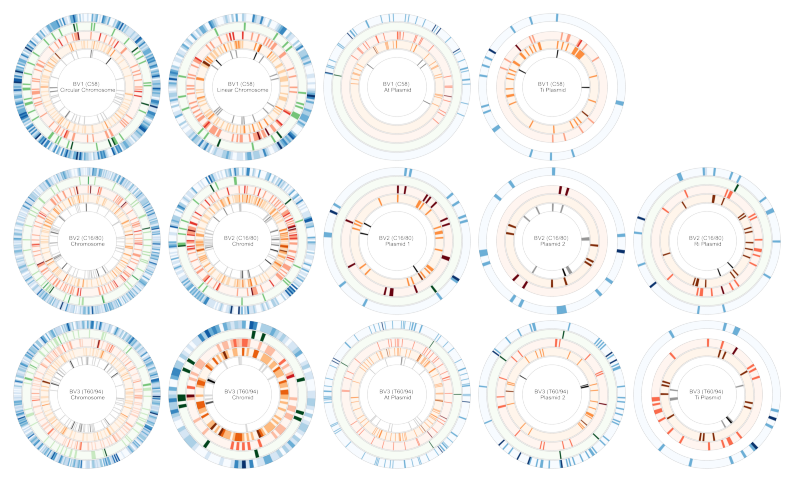

In [2]:
# IN='../../02-OUTPUT/04-TSS/TSS_GBK'

# plot_circos(f'{IN}/BV1-NC_003062.2','BV1 (C58) \n Circular Chromosome')
# plot_circos(f'{IN}/BV1-NC_003063.2','BV1 (C58) \n Linear Chromosome')
# plot_circos(f'{IN}/BV1-NC_003064.2','BV1 (C58) \n At Plasmid',1_000)
# plot_circos(f'{IN}/BV1-NC_003065.3','BV1 (C58) \n Ti Plasmid',1_000)

# plot_circos(f'{IN}/BV2-chromosome','BV2 (C16/80) \n Chromosome')
# plot_circos(f'{IN}/BV2-chromid','BV2 (C16/80) \n Chromid')
# plot_circos(f'{IN}/BV2-plasmid1','BV2 (C16/80) \n Plasmid 1',1_000)
# plot_circos(f'{IN}/BV3-plasmid2','BV3 (C16/80) \n Plasmid 2',1_000)
# plot_circos(f'{IN}/BV3-pTi','BV3 (C16/80) \n Ri Plasmid',1_000)

# plot_circos(f'{IN}/BV3-chromosome','BV3 (T60/94) \n Chromosome')
# plot_circos(f'{IN}/BV3-chromid','BV3 (T60/94) \n Chromid')
# plot_circos(f'{IN}/BV3-pAt','BV3 (T60/94) \n At Plasmid',1_000)
# plot_circos(f'{IN}/BV3-plasmid2','BV3 (T60/94) \n Plasmid 2',1_000)
# plot_circos(f'{IN}/BV3-pTi','BV3 (T60/94) \n Ti Plasmid',1_000)

fig, axarr = plt.subplots(3,5,figsize=(10,6))
CROP = 100
axarr[0,0].imshow(plt.imread(f'{OUT_DIR}/fig4_BV1-NC_003062.2.png')[CROP:-CROP,CROP:-CROP])
axarr[0,0].axis('off')
axarr[0,1].imshow(plt.imread(f'{OUT_DIR}/fig4_BV1-NC_003063.2.png')[CROP:-CROP,CROP:-CROP])
axarr[0,1].axis('off')
axarr[0,2].imshow(plt.imread(f'{OUT_DIR}/fig4_BV1-NC_003064.2.png')[CROP:-CROP,CROP:-CROP])
axarr[0,2].axis('off')
axarr[0,3].imshow(plt.imread(f'{OUT_DIR}/fig4_BV1-NC_003065.3.png')[CROP:-CROP,CROP:-CROP])
axarr[0,3].axis('off')
axarr[0,4].axis('off')

axarr[1,0].imshow(plt.imread(f'{OUT_DIR}/fig4_BV2-chromosome.png')[CROP:-CROP,CROP:-CROP])
axarr[1,0].axis('off')
axarr[1,1].imshow(plt.imread(f'{OUT_DIR}/fig4_BV2-chromid.png')[CROP:-CROP,CROP:-CROP])
axarr[1,1].axis('off')
axarr[1,2].imshow(plt.imread(f'{OUT_DIR}/fig4_BV2-plasmid1.png')[CROP:-CROP,CROP:-CROP])
axarr[1,2].axis('off')
axarr[1,3].imshow(plt.imread(f'{OUT_DIR}/fig4_BV2-plasmid2.png')[CROP:-CROP,CROP:-CROP])
axarr[1,3].axis('off')
axarr[1,4].imshow(plt.imread(f'{OUT_DIR}/fig4_BV2-pTi.png')[CROP:-CROP,CROP:-CROP])
axarr[1,4].axis('off')

axarr[2,0].imshow(plt.imread(f'{OUT_DIR}/fig4_BV3-chromosome.png')[CROP:-CROP,CROP:-CROP])
axarr[2,0].axis('off')
axarr[2,1].imshow(plt.imread(f'{OUT_DIR}/fig4_BV3-chromid.png')[CROP:-CROP,CROP:-CROP])
axarr[2,1].axis('off')
axarr[2,2].imshow(plt.imread(f'{OUT_DIR}/fig4_BV3-pAt.png')[CROP:-CROP,CROP:-CROP])
axarr[2,2].axis('off')
axarr[2,3].imshow(plt.imread(f'{OUT_DIR}/fig4_BV3-plasmid2.png')[CROP:-CROP,CROP:-CROP])
axarr[2,3].axis('off')
axarr[2,4].imshow(plt.imread(f'{OUT_DIR}/fig4_BV3-pTi.png')[CROP:-CROP,CROP:-CROP])
axarr[2,4].axis('off')

fig.subplots_adjust(hspace=0,wspace=0)
fig.savefig(f'{OUT_DIR}/fig4.png',dpi=300,transparent=True,bbox_inches='tight')


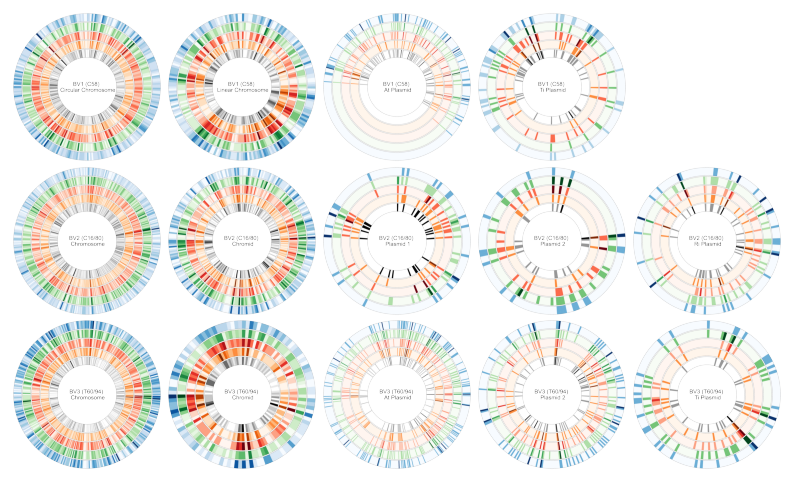

In [3]:
# IN='../../02-OUTPUT/04-TSS/TSS_GBK'
# plot_circos_conditions(f'{IN}/BV1-NC_003062.2','BV1 (C58) \n Circular Chromosome')
# plot_circos_conditions(f'{IN}/BV1-NC_003063.2','BV1 (C58) \n Linear Chromosome')
# plot_circos_conditions(f'{IN}/BV1-NC_003064.2','BV1 (C58) \n At Plasmid',1_000)
# plot_circos_conditions(f'{IN}/BV1-NC_003065.3','BV1 (C58) \n Ti Plasmid',1_000)

# plot_circos_conditions(f'{IN}/BV2-chromosome','BV2 (C16/80) \n Chromosome')
# plot_circos_conditions(f'{IN}/BV2-chromid','BV2 (C16/80) \n Chromid')
# plot_circos_conditions(f'{IN}/BV2-plasmid1','BV2 (C16/80) \n Plasmid 1',1_000)
# plot_circos_conditions(f'{IN}/BV2-plasmid2','BV2 (C16/80) \n Plasmid 2',1_000)
# plot_circos_conditions(f'{IN}/BV2-pTi','BV2 (C16/80) \n Ri Plasmid',1_000)

# plot_circos_conditions(f'{IN}/BV3-chromosome','BV3 (T60/94) \n Chromosome')
# plot_circos_conditions(f'{IN}/BV3-chromid','BV3 (T60/94) \n Chromid')
# plot_circos_conditions(f'{IN}/BV3-pAt','BV3 (T60/94) \n At Plasmid',1_000)
# plot_circos_conditions(f'{IN}/BV3-plasmid2','BV3 (T60/94) \n Plasmid 2',1_000)
# plot_circos_conditions(f'{IN}/BV3-pTi','BV3 (T60/94) \n Ti Plasmid',1_000)

fig, axarr = plt.subplots(3,5,figsize=(10,6))
CROP = 100
axarr[0,0].imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV1-NC_003062.2.png')[CROP:-CROP,CROP:-CROP])
axarr[0,0].axis('off')
axarr[0,1].imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV1-NC_003063.2.png')[CROP:-CROP,CROP:-CROP])
axarr[0,1].axis('off')
axarr[0,2].imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV1-NC_003064.2.png')[CROP:-CROP,CROP:-CROP])
axarr[0,2].axis('off')
axarr[0,3].imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV1-NC_003065.3.png')[CROP:-CROP,CROP:-CROP])
axarr[0,3].axis('off')
axarr[0,4].axis('off')

axarr[1,0].imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV2-chromosome.png')[CROP:-CROP,CROP:-CROP])
axarr[1,0].axis('off')
axarr[1,1].imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV2-chromid.png')[CROP:-CROP,CROP:-CROP])
axarr[1,1].axis('off')
axarr[1,2].imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV2-plasmid1.png')[CROP:-CROP,CROP:-CROP])
axarr[1,2].axis('off')
axarr[1,3].imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV2-plasmid2.png')[CROP:-CROP,CROP:-CROP])
axarr[1,3].axis('off')
axarr[1,4].imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV2-pTi.png')[CROP:-CROP,CROP:-CROP])
axarr[1,4].axis('off')

axarr[2,0].imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV3-chromosome.png')[CROP:-CROP,CROP:-CROP])
axarr[2,0].axis('off')
axarr[2,1].imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV3-chromid.png')[CROP:-CROP,CROP:-CROP])
axarr[2,1].axis('off')
axarr[2,2].imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV3-pAt.png')[CROP:-CROP,CROP:-CROP])
axarr[2,2].axis('off')
axarr[2,3].imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV3-plasmid2.png')[CROP:-CROP,CROP:-CROP])
axarr[2,3].axis('off')
axarr[2,4].imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV3-pTi.png')[CROP:-CROP,CROP:-CROP])
axarr[2,4].axis('off')

fig.subplots_adjust(hspace=0,wspace=0)
fig.savefig(f'{OUT_DIR}/si_conditions.png',dpi=300,transparent=True,bbox_inches='tight')

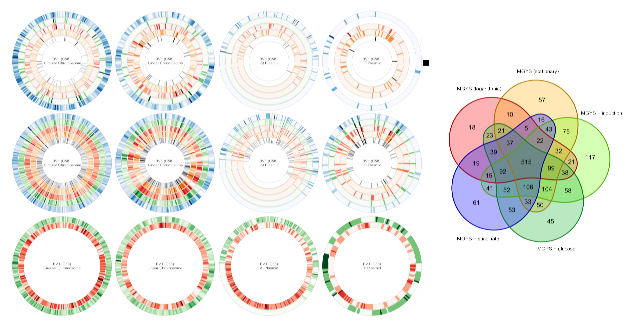

In [4]:
fig = plt.figure(figsize=(8,6.5))
gs = gridspec.GridSpec(6,6,hspace=-0.79,wspace=0.0)

CROP = 100

ax = fig.add_subplot(gs[0:1, 0])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV1-NC_003062.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[0:1, 1])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV1-NC_003063.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[0:1, 2])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV1-NC_003064.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[0:1, 3])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV1-NC_003065.3.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[2:3, 0])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV1-NC_003062.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[2:3, 1])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV1-NC_003063.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[2:3, 2])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV1-NC_003064.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[2:3, 3])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV1-NC_003065.3.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[4:5, 0])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV1-NC_003062.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[4:5, 1])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV1-NC_003063.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[4:5, 2])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV1-NC_003064.2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[4:5, 3])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV1-NC_003065.3.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[1:4, 4:])
ax.imshow(plt.imread(f'{OUT_DIR}/BV1_venn_all.png')[300:-300,300:-300])
ax.axis('off')

fig.savefig(f'{OUT_DIR}/fig4.png',dpi=600,transparent=True,bbox_inches='tight')
plt.show()

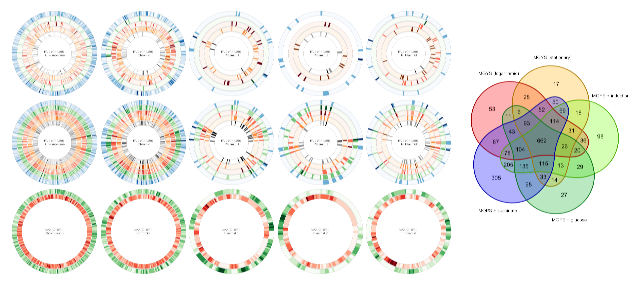

In [7]:
fig = plt.figure(figsize=(8,6.5))
gs = gridspec.GridSpec(6,7,hspace=-0.84,wspace=0.0)

CROP = 100

ax = fig.add_subplot(gs[0:1, 0])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV2-chromosome.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[0:1, 1])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV2-chromid.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[0:1, 2])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV2-plasmid1.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[0:1, 3])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV2-plasmid2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[0:1, 4])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV2-pTi.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[2:3, 0])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV2-chromosome.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[2:3, 1])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV2-chromid.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[2:3, 2])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV2-plasmid1.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[2:3, 3])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV2-plasmid2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[2:3, 4])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV2-pTi.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[4:5, 0])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV2-chromosome.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[4:5, 1])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV2-chromid.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[4:5, 2])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV2-plasmid1.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[4:5, 3])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV2-plasmid2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[4:5, 4])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV2-pTi.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[1:4, 5:])
ax.imshow(plt.imread(f'{OUT_DIR}/BV2_venn_all.png')[550:-550,550:-550])
ax.axis('off')

fig.savefig(f'{OUT_DIR}/BV2_circles.png',dpi=600,transparent=True,bbox_inches='tight')
plt.show()

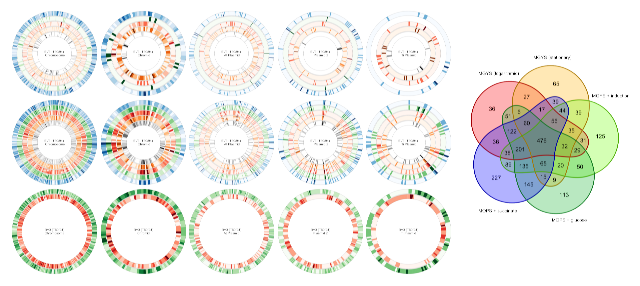

In [8]:
fig = plt.figure(figsize=(8,6.5))
gs = gridspec.GridSpec(6,7,hspace=-0.84,wspace=0.0)

CROP = 100

ax = fig.add_subplot(gs[0:1, 0])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV3-chromosome.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[0:1, 1])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV3-chromid.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[0:1, 2])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV3-pAt.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[0:1, 3])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV3-plasmid2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[0:1, 4])
ax.imshow(plt.imread(f'{OUT_DIR}/fig4_BV3-pTi.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[2:3, 0])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV3-chromosome.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[2:3, 1])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV3-chromid.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[2:3, 2])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV3-pAt.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[2:3, 3])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV3-plasmid2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[2:3, 4])
ax.imshow(plt.imread(f'{OUT_DIR}/si_conditions_BV3-pTi.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[4:5, 0])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV3-chromosome.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[4:5, 1])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV3-chromid.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[4:5, 2])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV3-pAt.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[4:5, 3])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV3-plasmid2.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')
ax = fig.add_subplot(gs[4:5, 4])
ax.imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV3-pTi.png')[CROP:-CROP,CROP:-CROP])
ax.axis('off')

ax = fig.add_subplot(gs[1:4, 5:])
ax.imshow(plt.imread(f'{OUT_DIR}/BV3_venn_all.png')[550:-550,550:-550])
ax.axis('off')

fig.savefig(f'{OUT_DIR}/BV3_circles.png',dpi=600,transparent=True,bbox_inches='tight')
plt.show()